In [134]:
import torch
import math

# Just use for the plots at the end
import matplotlib.pyplot as plt
from numpy import exp,arange
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show

torch.set_grad_enabled(False)

In [135]:
class Module(object) :
    def __init__(self):
        super().__init__()
    
    def forward(self , *input):
        raise  NotImplementedError
        
    def backward(self , *gradwrtoutput):
        raise  NotImplementedError
        
    def param(self): # These are the layers of the network
        return  []

In [136]:
class Layer(Module):
    def __init__(self):
        super().__init__()
        self.dropout = False
        self.linear = False
        
    def is_dropout(self):
        self.dropout = True
    
    def is_linear(self):
        self.linear = True

In [137]:
class Sequential(Module):
    def __init__(self, param, Loss):
        super().__init__()
        self.model = (param)
        self.loss = Loss
    
    def forward(self, x):
        for layer in self.model:
            x = layer.forward(x)
        return x
    
    def backward(self, output, target):
        grad = self.loss.backward(target, output)
        
        for layer in reversed(self.model):
            grad = layer.backward(grad)
        
        Loss = self.loss.forward(target, output)
        return Loss
    
    def Train(self):
        for layer in self.model:
            if layer.dropout:
                layer.Train()
        
    def Eval(self):
        for layer in self.model:
            if layer.dropout:
                layer.Eval()
    
    def lr_method(self, method, lr):
        for layer in self.model:
            if layer.linear:
                layer.change_lr_method(method, lr)

In [138]:
class Linear(Layer):
    def __init__(self, in_, out_):
        super().__init__()
        self.in_ = in_
        self.out_ = out_
        self.is_linear()
        self.lr = 0.005
        self.lr_method = 'constant'
        
        # Capture the term at each layer before the passage in the layer
        # and the activation function.
        self.x = torch.zeros(out_)
        
        # Initialization of Adam for weight and bias
        self.beta1 = 0.9
        self.beta2 = 0.999
        self.eps = 1.0e-8
        self.eta = 1.0e-1
        self.mw = torch.zeros(out_)
        self.mb = torch.zeros(out_)
        self.vw = 0.0
        self.vb = 0.0
        
        # Initialization of the weights and the bias
        param = 1. / math.sqrt(in_)
        self.weight = torch.empty(self.in_, self.out_).uniform_(-param, param)
        self.bias = torch.empty(self.out_).uniform_(-param, param)
        
    def forward(self, x):
        self.x = x
        return x.mm(self.weight) + self.bias
    
    def set_Lr(self, lr):
        self.lr = lr
        return
        
    def backward(self, grad):
        
        if self.lr_method == "Adam":
            
            # Adam method for the learning rate
            gw = self.x.t().mm(grad)
            self.mw = ((self.beta1 * self.mw) + ((1 - self.beta1) * gw))
            mh = (1 / (1 - self.beta1)) * self.mw
            self.vw = ((self.beta2 * self.vw) + ((1 - self.beta2) * (gw.norm()**2)))
            vh = (1 / (1 - self.beta2)) * self.vw
            self.weight = self.weight - ((self.eta / (vh.sqrt() + self.eps)) * mh)

            self.mb = ((self.beta1 * self.mb) + ((1 - self.beta1) * grad))
            mh = (1 / (1 - self.beta1)) * self.mb
            self.vb = ((self.beta2 * self.vb) + ((1 - self.beta2) * (grad.norm()**2)))
            vh = (1 / (1 - self.beta2)) * self.vb
            self.bias = self.bias - ((self.eta / (vh.sqrt() + self.eps)) * mh)
            grad = grad.mm(self.weight.t())
            
        elif self.lr_method == "constant":
            
            # Constant learning rate
            self.weight = self.weight - self.lr * self.x.t().mm(grad)
            self.bias = self.bias - self.lr * grad * 1
            grad = grad.mm(self.weight.t())
            
        return grad
    
    def weight(self):
        return self.weight
    
    def bias(self):
        return self.bias
    
    def change_lr_method(self, method, lr):
        self.lr = lr
        self.lr_method = method

In [139]:
class Dropout(Layer) :
    def __init__(self):
        super().__init__()
        self.p = 0.
        self.is_dropout()
        self.train = True
        
    
    def forward(self, x):
        n = torch.ones(x.size())
        if self.train:
            n = torch.bernoulli(n) * (1 - self.p)
        return x * n
        
    def backward(self, x):
        return x
    
    def Train(self):
        self.train = True
        
    def Eval(self):
        self.train = False
        

In [140]:
class LossMSE(Layer):
    def __init__(self):
        super().__init__() 
    
    def forward(self, data_target, data_output):
        loss = (data_output - data_target).pow(2).sum()
        return loss
    
    def backward(self, data_target, data_output):
        dloss = 2 * (data_output - data_target)
        return dloss
    
    def is_MSE(self):
        return True

In [306]:
class CrossEntropyLoss(Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, data_target, data_output):
        output = data_output.to(dtype=torch.float)
        target = data_target.resize_(data_target.size(0), 1)
        
        zer = torch.zeros(target.size()).int()
        target = torch.cat((target,zer), 1)
    
        first_column = torch.tensor([0])
        loss = output.gather(1,target).index_select(1,first_column).exp()
        
        # To avoid numerical error in the computation
        maxx = loss.max()
        
        loss = (loss + maxx) / (output.exp().sum(1) + maxx)
        loss = -(loss.log().mean())
        return loss
    
    def backward(self, data_target, data_output):
        # New version
        N = data_target.size(0)
        dloss = data_output.exp()
        dloss = dloss / dloss.sum(1).resize_(N,1)
        
        add = data_target-1
        add = torch.cat((add, -data_target), 1)
        dloss = (1/N) * (dloss + add)
        return dloss
    
    def is_MSE(self):
        return False

In [307]:
class ReLU(Layer):
    
    def __init__(self ):
        super().__init__()
        self.save = 0
        
    def forward(self, x):
        y = x.clamp(min = 0)
        self.save = x
        return y
    
    def backward(self, x):
        y = self.save > 0
        return y.float() * x
         
    def print(self):
        return

In [308]:
class Leaky_ReLU(Layer):
    
    def __init__(self ):
        super().__init__()
        self.s = 0
        self.alpha = 0.01
        
    def forward(self, x):
        y = torch.maximum(self.alpha * x, x)
        self.s = x
        return y
    
    def backward(self, x):
        y = ((self.s > 0) * (1 - self.alpha)) + self.alpha
        return y.float() * x
         
    def print(self):
        return

In [309]:
class ELU(Layer):
    
    def __init__(self):
        super().__init__()
        self.s = 0
        self.alpha = 0.01
        
    def forward(self, x):
        y = ((x > 0).float() * x) + (0 >= x) * self.alpha * (torch.exp(x) - 1)
        self.s = x
        return y
    
    def backward(self, x):
        y = ((self.s > 0) * (1 - self.alpha * torch.exp(self.s))) + self.alpha * torch.exp(self.s)
        return y.float() * x

In [310]:
class Tanh(Layer) :
    def __init__(self, ):
        super().__init__()
        self.save = 0
    
    def  forward(self, x):
        self.save = x
        return torch.div(x.exp() - (-x).exp(), x.exp() + (-x).exp())
        
    def  backward(self, x):
        return (1 - torch.div(self.save.exp() - 
                    (-self.save).exp(), self.save.exp() + (-self.save).exp())**2) * x
        
    def print(self):
        return

In [311]:
class Sigmoid(Layer):
    
    def __init__(self):
        super().__init__()
        self.s = 0
        self.lbd = 3
        
    def forward(self, x):
        y = 1 / (1 + torch.exp(-self.lbd * x))
        self.s = x
        return y
    
    def backward(self, x):
        y = self.lbd * torch.exp(-self.s) / ((1 + torch.exp(-self.lbd * self.s))**2)
        return y.float() * x  

In [312]:
def create_random_batch(input_size, mini_batch_size):
    
    # This function return a 2D tensor that is the rando selection of inputs for our
    # stochastic gradient method, taking in count the number of mini_batches.
    
    # We suppose here that our mini_batch_size is well chosen taking in count the fact
    # that it divides input_size.
    
    # Initialization
    L = int(input_size / mini_batch_size)
    new_batch = torch.ones(L, mini_batch_size)
    
    indices = torch.randperm(input_size)
    for k in range(L):
        new_batch[k] = indices[k * mini_batch_size : (k+1) * mini_batch_size]
    
    return new_batch

In [313]:
def train_model(model, train_input, train_classes, nb_epochs, mini_batch_size):
    
    h_step = 1e-3
    
    for epoch in range(nb_epochs):
        random_batches = create_random_batch(train_input.size(0), mini_batch_size).tolist()
        for batch in range(0, train_input.size(0), mini_batch_size):
            output = model.forward(train_input.narrow(0, batch, mini_batch_size))
            loss = model.backward(output, train_classes.narrow(0, batch, mini_batch_size))

In [314]:
def compute_nb_errors(model, data_input, data_target, mini_batch_size):
    
    nb_data_errors = 0

    for b in range(0, data_input.size(0), mini_batch_size):
        result = model.forward(data_input.narrow(0, b, mini_batch_size))
        
        if model.loss.is_MSE():
            # If the loss function is MSE
            predicted_classes = (result >= 0.5).int()
        else:
            # If the loss function is CrossEntropy
            _, predicted_classes = torch.max(result, 1)
        
        for k in range(mini_batch_size):
            if data_target[b + k] != predicted_classes[k]:
                nb_data_errors = nb_data_errors + 1
                
    return nb_data_errors

In [315]:
def create_problem(nb_samples):
    
    # Remark: the function .uniform return a uniform distribution on [0,1) instead of [0,1],
    # but in our case it's not a problem since it is only a train and a test set on a circle
    # that do not touch the border of the set [0,1]^2.
    train_input = torch.empty(nb_samples, 2).uniform_(0, 1)
    test_input = torch.empty(nb_samples, 2).uniform_(0, 1)
    
    # Radius of our circle
    R = 1 / math.sqrt(2 * math.pi)
    
    train_classes = train_input.sub(0.5).pow(2).sum(1).sub(R**2).sign().sub(1).div(-2).long().resize_((nb_samples,1))
    test_classes = test_input.sub(0.5).pow(2).sum(1).sub(R**2).sign().sub(1).div(-2).long().resize_((nb_samples,1))
    
    return train_input, train_classes, test_input, test_classes

In [316]:
def get_tests(n):
    M = []
    for k in range (n):
        L = []
        _, _, test_input, test_classes =  create_problem(1000)
        L.append(test_input)
        L.append(test_classes)
        M.append(L)
    return M

In [317]:
train_input, train_classes, _, _ = create_problem(1000)
#print(train_input.size())
#print(train_input.narrow(0, b, mini_batch_size).size())
nb_epochs = 100
mini_batch_size = 10

model = Sequential([Linear(2,25), Leaky_ReLU(), Linear(25,25), Leaky_ReLU(), Linear(25,2), Leaky_ReLU()], CrossEntropyLoss())
model.lr_method("Adam", 1.0e-3)
train_model(model, train_input, train_classes, nb_epochs, mini_batch_size)

In [318]:
nb_train_errors = compute_nb_errors(model, train_input, train_classes, mini_batch_size)
print('train error {:0.2f}% {:f}/{:f}'.format((100 * nb_train_errors) / train_input.size(0), nb_train_errors, train_classes.size(0)))

L = get_tests(10)
average_nb_test_error = 0
for k in range (0, len(L)):
    nb_test_errors = compute_nb_errors(model, L[k][0], L[k][1], mini_batch_size)
    average_nb_test_error += nb_test_errors
    print('test error {:0.2f}% {:f}/{:f}'.format((100 * nb_test_errors) / L[k][0].size(0), nb_test_errors, L[k][0].size(0)))
print('Average test error {:0.2f}% {:0.1f}/{:d}'.format((100*average_nb_test_error/len(L)) / L[0][0].size(0), average_nb_test_error/len(L), L[0][0].size(0)))

train error 1.30% 13.000000/1000.000000
test error 4.10% 41.000000/1000.000000
test error 5.90% 59.000000/1000.000000
test error 4.20% 42.000000/1000.000000
test error 4.00% 40.000000/1000.000000
test error 3.80% 38.000000/1000.000000
test error 4.30% 43.000000/1000.000000
test error 5.00% 50.000000/1000.000000
test error 4.80% 48.000000/1000.000000
test error 4.20% 42.000000/1000.000000
test error 4.70% 47.000000/1000.000000
Average test error 4.50% 45.0/1000


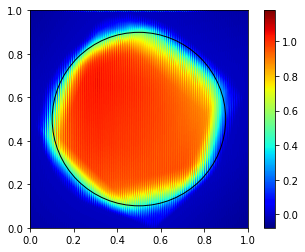

In [158]:
x = torch.linspace(0.0, 1.0, 1000)
y = torch.linspace(0.0, 1.0, 1000)
n = x.size(0)
grid_x, grid_y = torch.meshgrid(x,y)
Z = torch.empty(grid_x.size())
for k in range(grid_x.size(0)):
    for l in range(0, n, mini_batch_size):        
        xx = grid_x[k][l:l+mini_batch_size].t().resize_((mini_batch_size,1))
        yy = grid_y[k][l:l+mini_batch_size].t().resize_((mini_batch_size,1))
        e = torch.cat([xx, yy], 1)
        Z[k][l:l+mini_batch_size] = model.forward(e).resize(mini_batch_size)
    

def showTensor(aTensor):
    figure, axes = plt.subplots()
    
    color_map = plt. cm. get_cmap('jet')
    reversed_color_map = color_map.reversed()
    
    im = imshow(aTensor.numpy(), origin='lower', extent=[0,1,0,1], cmap=reversed_color_map)
    
    cset = contour(aTensor,arange(0.5,1.5,1),linewidths=1.0,
                       origin='lower', extent=[0,1,0,1])
    clabel(cset,inline=True,fmt='%1.1f',fontsize=10)
    
    # Radius of our circle
    R = 1 / math.sqrt(2 * math.pi)
    Drawing_uncolored_circle = plt.Circle((0.5, 0.5 ), R, edgecolor=(0, 0, 0), fill=False, linestyle = '--')
    axes.set_aspect(1)
    axes.add_artist(Drawing_uncolored_circle)
    
    colorbar(im)
    plt.show()
    
showTensor(Z);

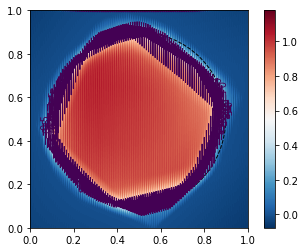

In [159]:
# Show the tensor.xt
def showTensor(aTensor):
    figure, axes = plt.subplots()
    
    color_map = plt. cm. get_cmap('RdBu')
    reversed_color_map = color_map.reversed()
    
    im = imshow(aTensor.numpy(), origin='lower', extent=[0,1,0,1], cmap=reversed_color_map)
    
    cset = contour(aTensor,arange(0.5,1.5,1),linewidths=1.0,
                       origin='lower', extent=[0,1,0,1])
    clabel(cset,inline=True,fmt='%1.1f',fontsize=10)
    
    # Radius of our circle
    R = 1 / math.sqrt(2 * math.pi)
    Drawing_uncolored_circle = plt.Circle((0.5, 0.5 ), R, edgecolor=(0, 0, 0), fill=False, linestyle = '--')
    axes.set_aspect(1)
    axes.add_artist(Drawing_uncolored_circle)
    
    colorbar(im)
    plt.show()
    
showTensor(Z);

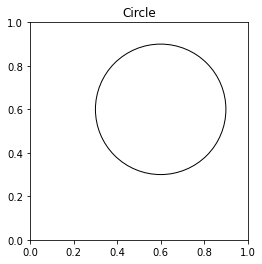

In [73]:
import matplotlib.pyplot as plt
  
figure, axes = plt.subplots()
Drawing_uncolored_circle = plt.Circle( (0.6, 0.6 ),
                                      0.3 ,
                                      fill = False )
  
axes.set_aspect( 1 )
axes.add_artist( Drawing_uncolored_circle )
plt.title( 'Circle' )
plt.show()

[[ 0.00234479  0.00324714  0.00444356 ...  0.00600968  0.00444356
   0.00324714]
 [ 0.00271656  0.00378003  0.00519529 ...  0.00705412  0.00519529
   0.00378003]
 [ 0.00307523  0.00430508  0.00594913 ...  0.00811726  0.00594913
   0.00430508]
 ...
 [-0.00803313 -0.01055955 -0.01374627 ... -0.01772211 -0.01374627
  -0.01055955]
 [-0.00660186 -0.00869247 -0.01133452 ... -0.01463719 -0.01133452
  -0.00869247]
 [-0.00536864 -0.00707941 -0.00924518 ... -0.0119572  -0.00924518
  -0.00707941]]


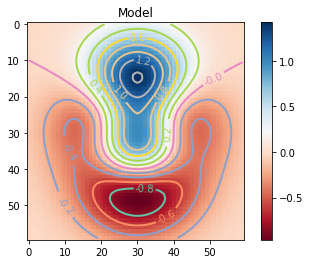

In [65]:
from numpy import exp,arange
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show
# the function that I'm going to plot
def z_func(x,y):
 return (1-(x**2+y**3))*exp(-(x**2+y**2)/2)

x = arange(-3.0,3.0,0.1)
y = arange(-3.0,3.0,0.1)
X,Y = meshgrid(x, y) # grid of point
Z = z_func(X, Y) # evaluation of the function on the grid
print(Z)

im = imshow(Z,cmap=cm.RdBu) # drawing the function
# adding the Contour lines with labels
cset = contour(Z,arange(-1,1.5,0.2),linewidths=2,cmap=cm.Set2)
clabel(cset,inline=True,fmt='%1.1f',fontsize=10)
colorbar(im) # adding the colobar on the right
# latex fashion title
title('Model')
show()

In [23]:
x = torch.tensor([True, False]).float()
print(x)
for i in arange(-1,1.5,0.2):
    print(i)

tensor([1., 0.])


NameError: name 'arange' is not defined

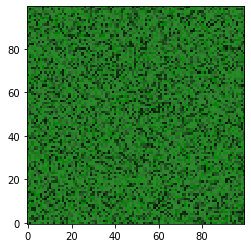

In [40]:
from matplotlib.colors import colorConverter
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

# create dummy data
zvals = np.ones((100,100))# np.random.rand(100,100)*10-5
zvals2 = np.random.rand(100,100)*10-5

# generate the colors for your colormap
color1 = colorConverter.to_rgba('white')
color2 = colorConverter.to_rgba('black')

# make the colormaps
cmap1 = mpl.colors.LinearSegmentedColormap.from_list('my_cmap',['green','blue'],256)
cmap2 = mpl.colors.LinearSegmentedColormap.from_list('my_cmap2',[color1,color2],256)

cmap2._init() # create the _lut array, with rgba values

# create your alpha array and fill the colormap with them.
# here it is progressive, but you can create whathever you want
alphas = np.linspace(0, 0.8, cmap2.N+3)
cmap2._lut[:,-1] = alphas

img2 = plt.imshow(zvals, interpolation='nearest', cmap=cmap1, origin='lower')
img3 = plt.imshow(zvals2, interpolation='nearest', cmap=cmap2, origin='lower')

plt.show()